In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

In [3]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

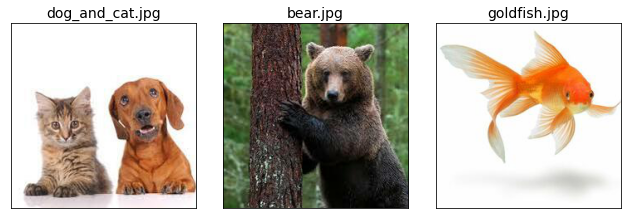

In [18]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

# Image titles
image_titles = ['dog_and_cat.jpg','bear.jpg','goldfish.jpg']

# Load images
img1 = load_img('/home/tseibel/dog_and_cat.jpg')
img2 = load_img('/home/tseibel/bear.jpg')
img3 = load_img('/home/tseibel/goldfish.jpg')
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

#images = np.asarray([np.array(img1)])

# Preparing input data
X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()

In [19]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][1], output[1][294], output[2][413])

In [20]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

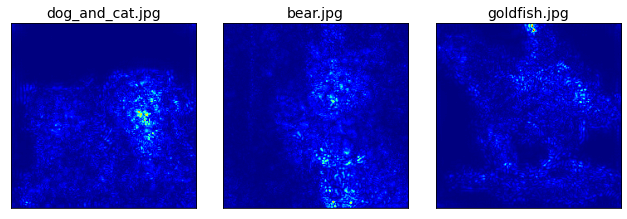

CPU times: user 1.88 s, sys: 870 ms, total: 2.75 s
Wall time: 1.87 s


In [21]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
# If `clone` is True(default), the `model` will be cloned,
# so the `model` instance will be NOT modified, but it takes a machine resources.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map
saliency_map = saliency(loss, X)
saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.show()

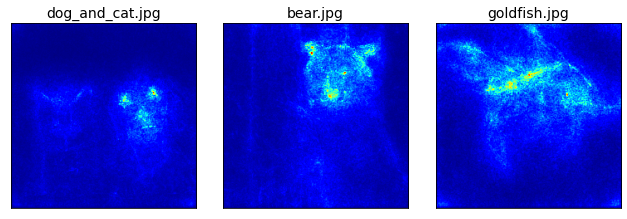

CPU times: user 2.3 s, sys: 908 ms, total: 3.2 s
Wall time: 3.06 s


In [23]:
%%time

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('/home/tseibel/smoothgrad.png')
plt.show()